# 🏭 Smart CNC: Predictive Maintenance Model Training

**Project:** Smart CNC Analytics & ROI Dashboard
**Author:** Watcharapon Anaketanaset
**Objective:** To build a robust predictive maintenance system using a hybrid approach of **Machine Learning (XGBoost/LightGBM)**, **Deep Learning (1D-CNN)**, and **Generative AI (RAG)**.

---

### Project Workflow
1.  **Feature Engineering:** incorporating physics-based features (Power, Temp Rise).
2.  **Model Benchmarking:** Comparing Logistic Regression, LightGBM, XGBoost, and CNN.
3.  **Hyperparameter Tuning:** Optimizing class weights to handle imbalanced data.
4.  **Cost Analysis:** Calculating financial impact based on the Confusion Matrix.
5.  **AI Consultant (RAG):** Using Google Gemini + LangChain to answer technical questions from engineering manuals.

## Importing Libraries & Dataset
First, imported the necessary libraries for data manipulation (Pandas), visualization (Seaborn/Matplotlib), and Machine Learning (Scikit-learn).

**Dataset:** Using the **AI4I 2020 Predictive Maintenance Dataset** from the UCI Machine Learning Repository, which contains synthetic data reflecting real-world predictive maintenance scenarios.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. ดูดไฟล์ Dataset (Download Data) ---
print("⏳ กำลังดาวน์โหลดข้อมูล... (Downloading data from UCI Repository)")
!wget -q https://archive.ics.uci.edu/static/public/601/ai4i+2020+predictive+maintenance+dataset.zip
!unzip -q -o "ai4i+2020+predictive+maintenance+dataset.zip"
print("✅ ดาวน์โหลดและแตกไฟล์เรียบร้อย! (Download Complete)")

# --- 2. โหลดข้อมูล (Load Data) ---
df = pd.read_csv("ai4i2020.csv")

# เปลี่ยนชื่อ Column และทำความเข้าใจตัวแปร (Variable Dictionary)
df.columns = [
    "UDI",             # Unique Identifier (รหัสรันนัมเบอร์ - ตัดทิ้งได้)
    "Product_ID",      # Product ID (รหัสสินค้า)
    "Type",            # Quality Type L/M/H (เกรดสินค้า: Low, Medium, High)
    "Air_Temp",        # Air Temperature [K] (อุณหภูมิห้อง / อุณหภูมิอากาศ)
    "Process_Temp",    # Process Temperature [K] (อุณหภูมิขณะทำงานจริง)
    "Speed_RPM",       # Rotational Speed [rpm] (ความเร็วรอบ)
    "Torque_Nm",       # Torque [Nm] (แรงบิด)
    "Tool_Wear_min",   # Tool Wear [min] (เวลาที่ทูลถูกใช้งานไปแล้ว / ความสึกหรอสะสม)
    "Machine_Failure", # Machine Failure Label (สถานะเครื่องจักร: 0=ปกติ, 1=พัง)
    "TWF",             # Tool Wear Failure (พังเพราะทูลสึกหรอ/หมดอายุ)
    "HDF",             # Heat Dissipation Failure (พังเพราะระบายความร้อนไม่ทัน)
    "PWF",             # Power Failure (พังเพราะกินกำลังไฟผิดปกติ)
    "OSF",             # Overstrain Failure (พังเพราะรับภาระหนักเกิน/Overload)
    "RNF"              # Random Failure (พังแบบสุ่ม/หาสาเหตุชัดเจนไม่ได้)
]

⏳ กำลังดาวน์โหลดข้อมูล... (Downloading data from UCI Repository)
✅ ดาวน์โหลดและแตกไฟล์เรียบร้อย! (Download Complete)


## 1. Feature Engineering
Instead of relying solely on raw sensor data, we apply engineering domain knowledge to create new features that better represent the machine's stress level.

**New Features:**
1.  **Power (W):** Calculated using the formula $P = \tau \times \omega$.
    * $\text{Power} [W] = \text{Torque} [Nm] \times \text{Rotational Speed} [rad/s]$
    * (Note: $1 \text{ RPM} \approx 0.1047 \text{ rad/s}$)
2.  **Temperature Rise:** The difference between *Process Temperature* and *Air Temperature*, indicating the heat generation efficiency.

*(These features help the model detect "Overstrain" and "Heat Dissipation" failures more accurately.)*

In [ ]:
# --- 3. 🔧 Feature Engineering ---
# : Power (Watt) = Torque (N.m) * Speed (rad/s)
# 1 RPM = 0.1047 rad/s
# Insight: "กำลังไฟฟ้าที่ใช้จริง" (Power Consumption)
df['Power_W'] = df['Torque_Nm'] * df['Speed_RPM'] * 0.1047

# : ความร้อนสะสม (Temperature Difference)
# Insight: ถ้าความร้อนขึ้นสูงกว่าอุณหภูมิห้องมากเกินไป = เสี่ยง Heat Failure
df['Temp_Rise'] = df['Process_Temp'] - df['Air_Temp']

In [ ]:
print("ตัวอย่างข้อมูลหลังทำ Feature Engineering:")
# เลือกโชว์เฉพาะคอลัมน์สำคัญ
cols_to_show = ['Speed_RPM', 'Torque_Nm', 'Power_W', 'Process_Temp', 'Air_Temp', 'Temp_Rise', 'Machine_Failure']
print(df[cols_to_show].head())

ตัวอย่างข้อมูลหลังทำ Feature Engineering:
   Speed_RPM  Torque_Nm     Power_W  Process_Temp  Air_Temp  Temp_Rise  \
0       1551       42.8  6950.27916         308.6     298.1       10.5   
1       1408       46.3  6825.43488         308.7     298.2       10.5   
2       1498       49.4  7747.92564         308.5     298.1       10.4   
3       1433       39.5  5926.38645         308.6     298.2       10.4   
4       1408       40.0  5896.70400         308.7     298.2       10.5   

   Machine_Failure  
0                0  
1                0  
2                0  
3                0  
4                0  


In [ ]:
# --- 4. 🔍 ส่องข้อมูล (Data Analysis) ---
# นับจำนวนเคสที่พังแยกตามประเภท (Failure Type Distribution)
failure_counts = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum()
total_machines = len(df)
failed_machines = df['Machine_Failure'].sum()

print("\n" + "="*50)
print(f"📊 สรุปข้อมูลทั้งหมด (Total Machines): {total_machines} เครื่อง")
print(f"❌ เครื่องที่พังมี (Failed Machines):    {failed_machines} เครื่อง")
print("="*50)

print("\n🔍 สาเหตุการพัง เรียงจากมากไปน้อย (Failure Causes - Sorted):")
failure_summary = failure_counts.sort_values(ascending=False)
print(failure_summary)
print("\n[คำอธิบายย่อ / Cheat Sheet]")
print("OSF = Overstrain Failure (รับภาระเกิน/Overload)")
print("HDF = Heat Dissipation Failure (ร้อนเกิน)")
print("PWF = Power Failure (กำลังไฟผิดปกติ)")
print("TWF = Tool Wear Failure (ทูลหมดอายุ)")
print("RNF = Random Failure (แรนดอม)")
print("-" * 50)


📊 สรุปข้อมูลทั้งหมด (Total Machines): 10000 เครื่อง
❌ เครื่องที่พังมี (Failed Machines):    339 เครื่อง

🔍 สาเหตุการพัง เรียงจากมากไปน้อย (Failure Causes - Sorted):
HDF    115
OSF     98
PWF     95
TWF     46
RNF     19
dtype: int64

[คำอธิบายย่อ / Cheat Sheet]
OSF = Overstrain Failure (รับภาระเกิน/Overload)
HDF = Heat Dissipation Failure (ร้อนเกิน)
PWF = Power Failure (กำลังไฟผิดปกติ)
TWF = Tool Wear Failure (ทูลหมดอายุ)
RNF = Random Failure (แรนดอม)
--------------------------------------------------


## 2. Exploratory Data Analysis (EDA)
We visualize the relationship between **Power Consumption** and **Tool Wear**.

* **X-axis:** Tool Wear (min) - How long the tool has been used.
* **Y-axis:** Power (W) - The energy required to cut the material.
* **Color:** Failure Status (Red = Failed, Blue = Normal).

**Hypothesis:** Failures should cluster in the "High Wear + High Power" region (Top-Right), indicating the tool is blunt and requires more energy to cut.


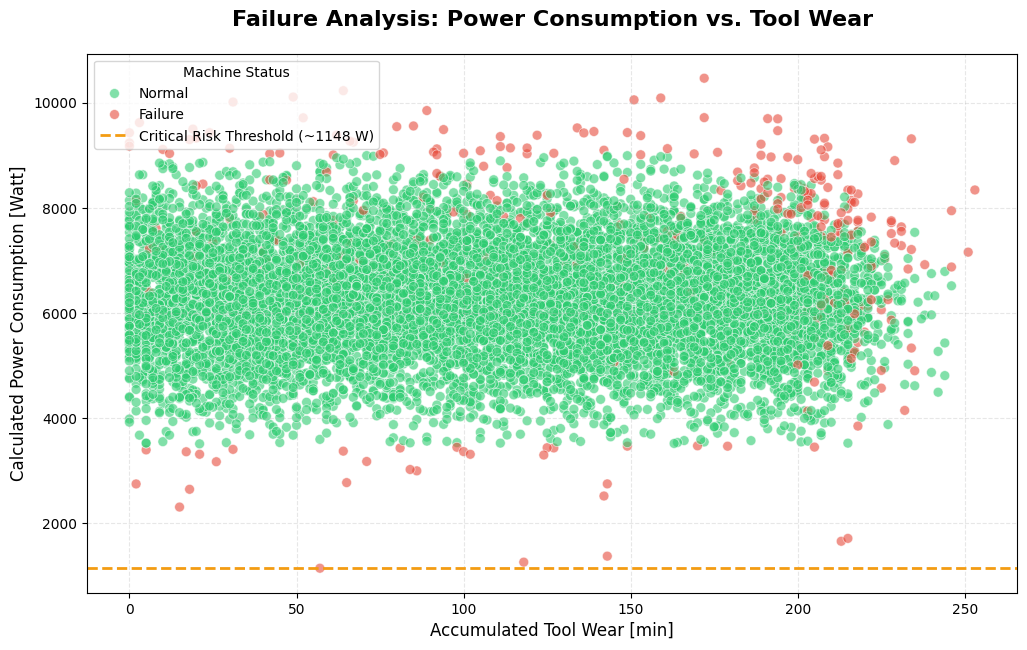

In [ ]:
# --- 5. 🔍 Data Visualization ---

# 1. 🔧 สร้างคอลัมน์ใหม่สำหรับทำ Legend โดยเฉพาะ (Explicit is better than implicit)
# map 0 -> 'Normal', 1 -> 'Failure'
df['Machine_Status'] = df['Machine_Failure'].map({0: 'Normal', 1: 'Failure'})

plt.figure(figsize=(12, 7))

# 2. สร้าง Scatter Plot โดยใช้คอลัมน์ใหม่ที่เป็นตัวหนังสือ
sns.scatterplot(data=df, x='Tool_Wear_min', y='Power_W',
                hue='Machine_Status',  # ใช้คอลัมน์ใหม่
                hue_order=['Normal', 'Failure'], # บังคับลำดับให้ Normal มาก่อน
                palette={'Normal':'#2ecc71', 'Failure':'#e74c3c'}, # กำหนดสีให้ตรงกับคำ
                alpha=0.6, s=50)

# 3. ปรับแต่ง Title และ Label
plt.title("Failure Analysis: Power Consumption vs. Tool Wear", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Accumulated Tool Wear [min]", fontsize=12)
plt.ylabel("Calculated Power Consumption [Watt]", fontsize=12)

# 4. เส้นขีดจำกัด (Threshold)
threshold_val = df[df['Machine_Failure']==1]['Power_W'].min()
plt.axhline(y=threshold_val, color='#f39c12', linestyle='--', linewidth=2,
            label=f'Critical Risk Threshold (~{threshold_val:.0f} W)')

# 5. Legend (คราวนี้ไม่ต้องแก้ label เองแล้ว เพราะมันดึงมาจากข้อมูลถูกต้องเป๊ะๆ)
plt.legend(title='Machine Status', loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()


## 4. Data Preprocessing
Preparing the data for the Machine Learning model:

* **Drop Columns:** Removing identifiers like `UDI` or `Product ID` that do not contribute to prediction.
* **Encoding:** Converting categorical variables (e.g., *Type L, M, H*) into numerical format.
* **Train-Test Split:** Splitting the dataset into **Training Set (80%)** for learning and **Testing Set (20%)** for evaluation.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- 1. โหลดข้อมูล ---
print("⏳ Downloading Data...")
!wget -q https://archive.ics.uci.edu/static/public/601/ai4i+2020+predictive+maintenance+dataset.zip
!unzip -q -o "ai4i+2020+predictive+maintenance+dataset.zip"

df = pd.read_csv("ai4i2020.csv")
df.columns = ["UDI", "Product_ID", "Type", "Air_Temp", "Process_Temp",
              "Speed_RPM", "Torque_Nm", "Tool_Wear_min", "Machine_Failure",
              "TWF", "HDF", "PWF", "OSF", "RNF"]

# --- 2. Feature Engineering ---
df['Power_W'] = df['Torque_Nm'] * df['Speed_RPM'] * 0.1047
df['Temp_Rise'] = df['Process_Temp'] - df['Air_Temp']
# แปลง Type L/M/H เป็นตัวเลข
df['Type_Code'] = df['Type'].map({'L': 0, 'M': 1, 'H': 2})

# --- 3. เลือก Feature และแบ่ง Train/Test ---
# เราไม่เอา TWF, HDF... มาเทรน เพราะนั่นคือ "เฉลย" ว่าพังเพราะอะไร
features = ['Type_Code', 'Air_Temp', 'Process_Temp', 'Speed_RPM',
            'Torque_Nm', 'Tool_Wear_min', 'Power_W', 'Temp_Rise']

X = df[features]
y = df['Machine_Failure']

# แบ่ง 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. Scaling (สำคัญมากสำหรับ Deep Learning) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data Prep เสร็จเรียบร้อย!")
print(f"📦 Training Data: {X_train.shape}")
print(f"📦 Testing Data:  {X_test.shape}")

⏳ Downloading Data...
✅ Data Prep เสร็จเรียบร้อย!
📦 Training Data: (8000, 8)
📦 Testing Data:  (2000, 8)


## 3. Model Training - Baseline (Logistic Regression)
We start with a simple **Logistic Regression** model to establish a baseline performance.

**Handling Imbalance:**
Since failures are rare (~3% of data), we use `class_weight='balanced'`. This tells the model to pay more attention to the minority class (Failures) by assigning them higher importance during training.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- 1. สร้างโมเดล (Create Model) ---
# เราตั้งค่า Hyperparameters ที่สำคัญไว้ดังนี้:
# class_weight='balanced': หัวใจสำคัญ! สั่งให้โมเดล "แคร์" เคสเครื่องพัง (1) เป็นพิเศษ
# max_iter=1000: ให้เวลาโมเดลคำนวณนานหน่อย (เผื่อข้อมูลซับซ้อน)
print("🔵 Logistic Regression (Baseline)...")
model_log = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

# --- 2. สอนโมเดล (Train) ---
# เอาข้อมูลที่ Scaled แล้ว (X_train_scaled) ไปสอนคู่กับเฉลย (y_train)
model_log.fit(X_train_scaled, y_train)

# --- 3. ลองทำนายข้อสอบ (Predict) ---
y_pred_log = model_log.predict(X_test_scaled)

# --- 4. ตรวจการบ้าน (Evaluate) ---
print("\n" + "="*30)
print(f"✅ Accuracy (ความแม่นรวม): {accuracy_score(y_test, y_pred_log):.4f}")
print(f"✅ F1-Score (ความแม่นเคสพัง): {f1_score(y_test, y_pred_log):.4f}")
print("="*30)

print("\n📝 Detailed Report:")
print(classification_report(y_test, y_pred_log, target_names=['Normal (ปกติ)', 'Failure (พัง)']))

🔵 Logistic Regression (Baseline)...

✅ Accuracy (ความแม่นรวม): 0.8575
✅ F1-Score (ความแม่นเคสพัง): 0.2928

📝 Detailed Report:
               precision    recall  f1-score   support

Normal (ปกติ)       0.99      0.86      0.92      1932
Failure (พัง)       0.18      0.87      0.29        68

     accuracy                           0.86      2000
    macro avg       0.59      0.86      0.61      2000
 weighted avg       0.97      0.86      0.90      2000



## 4. Model Training - LightGBM
Next, we try **LightGBM (Light Gradient Boosting Machine)**.

**Why LightGBM?**
* It uses a "Leaf-wise" tree growth strategy, which often results in higher accuracy than level-wise algorithms.
* It is extremely fast and handles large datasets efficiently.
* Great for capturing non-linear patterns in sensor data.

🟢 LightGBM (The Speedster)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ Accuracy (ความแม่นรวม): 0.9875
✅ F1-Score (ความแม่นเคสพัง): 0.8175

📝 Detailed Report:
               precision    recall  f1-score   support

Normal (ปกติ)       0.99      0.99      0.99      1932
Failure (พัง)       0.81      0.82      0.82        68

     accuracy                           0.99      2000
    macro avg       0.90      0.91      0.91      2000
 weighted avg       0.99      0.99      0.99      2000



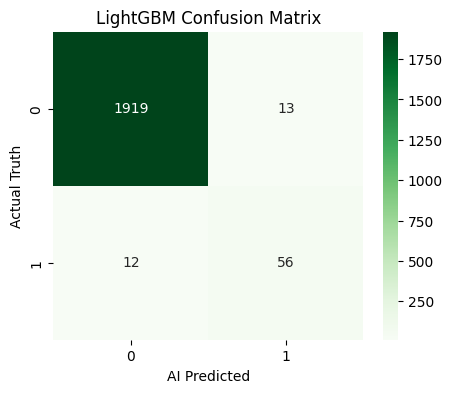

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. สร้างโมเดล (Create Model) ---
# LightGBM เป็นโมเดลที่ "เบาและไว" (Light & Fast)
# is_unbalance=True: บอกให้มันรู้ว่าข้อมูลเครื่องพังมีน้อย ให้ปรับสมดุลเอง
print("🟢 LightGBM (The Speedster)...")
model_lgbm = LGBMClassifier(
    random_state=42,
    n_estimators=100,    # สร้างต้นไม้ตัดสินใจ 100 ต้นช่วยกันคิด
    learning_rate=0.1,   # อัตราการเรียนรู้ (ไม่เร็วไป ไม่ช้าไป)
    is_unbalance=True,   # แก้เรื่องข้อมูลไม่สมดุล (Imbalance Handling)
    verbose=-1           # ปิดไม่ให้มันบ่นเยอะตอนเทรน
)

# --- 2. สอนโมเดล (Train) ---
model_lgbm.fit(X_train_scaled, y_train)

# --- 3. ลองทำนายข้อสอบ (Predict) ---
y_pred_lgbm = model_lgbm.predict(X_test_scaled)

# --- 4. ตรวจการบ้าน (Evaluate) ---
print("\n" + "="*30)
print(f"✅ Accuracy (ความแม่นรวม): {accuracy_score(y_test, y_pred_lgbm):.4f}")
print(f"✅ F1-Score (ความแม่นเคสพัง): {f1_score(y_test, y_pred_lgbm):.4f}")
print("="*30)

print("\n📝 Detailed Report:")
print(classification_report(y_test, y_pred_lgbm, target_names=['Normal (ปกติ)', 'Failure (พัง)']))

# แถม: กราฟ Confusion Matrix เพื่อดูว่าลด False Alarm ได้จริงไหม
cm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('LightGBM Confusion Matrix')
plt.xlabel('AI Predicted')
plt.ylabel('Actual Truth')
plt.show()

## 5. Model Training - XGBoost & Hyperparameter Tuning
We deploy **XGBoost**, a powerful gradient boosting algorithm known for its performance in Kaggle competitions.

**Critical Step: Weight Tuning (`scale_pos_weight`)**
Since the dataset is imbalanced, the default model might ignore failures. We iterate through different `scale_pos_weight` values (e.g., 10, 20, ..., 90) to find the "Sweet Spot" where **F1-Score** is maximized.

* **Too Low:** High Precision, but Low Recall (Misses failures).
* **Too High:** High Recall, but Low Precision (False alarms).
* **Goal:** Beat LightGBM's F1-Score of ~0.81.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# --- 1. ตั้งค่าโมเดล (Configuration) ---
print("🟠 XGBoost (The Challenger)...")

model_xgb = XGBClassifier(
    # 1. random_state: ล็อคผลให้เหมือนเดิมทุกครั้งที่รัน (สำคัญตอนพรีเซนต์)
    random_state=42,

    # 2. n_estimators: จำนวน "รอบ" ในการปรับปรุงโมเดล (จำนวนต้นไม้)
    # 100 ต้น กำลังดี ไม่น้อยไป ไม่เยอะจนเครื่องค้าง
    n_estimators=100,

    # 3. learning_rate: "ขนาดก้าว" ในการเรียนรู้
    # 0.1 แปลว่าค่อยๆ เรียนรู้ทีละนิด (ถ้าตั้งเยอะไป มันจะเรียนเร็วแต่ไม่ละเอียด)
    learning_rate=0.1,

    # 4. scale_pos_weight: **พระเอกของงานนี้** (สำคัญที่สุด!)
    # ข้อมูลเรามีเครื่องดี 96% เครื่องพัง 4%
    # ถ้าไม่ใส่ค่านี้ AI จะทายว่า "เครื่องดี" หมดเลยก็ได้คะแนน 96%
    # เราเลยสั่งว่า: (Positive case) ให้คูณความสำคัญไป 50 เท่านะ!"
    scale_pos_weight=50,

    # 5. eval_metric: วิธีวัดผลตอนเทรน
    # logloss คือสูตรคณิตศาสตร์มาตรฐานสำหรับการทายผลแพ้/ชนะ (Binary)
    eval_metric='logloss'
)

# --- 2. สอนโมเดล (Training) ---
# ขั้นตอนนี้คือให้วิศวกร 100 คนเริ่มรุมกันแก้งาน
model_xgb.fit(X_train_scaled, y_train)

# --- 3. สอบจริง (Testing) ---
y_pred_xgb = model_xgb.predict(X_test_scaled)

# --- 4. ตรวจผลงาน (Evaluation) ---
print("\n" + "="*30)
print(f"✅ Accuracy (ความแม่นรวม): {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"✅ F1-Score (ความแม่นเคสพัง): {f1_score(y_test, y_pred_xgb):.4f}")
print("="*30)

print("\n📝 Detailed Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=['Normal (ปกติ)', 'Failure (พัง)']))

🟠 XGBoost (The Challenger)...

✅ Accuracy (ความแม่นรวม): 0.9815
✅ F1-Score (ความแม่นเคสพัง): 0.7483

📝 Detailed Report (XGBoost):
               precision    recall  f1-score   support

Normal (ปกติ)       0.99      0.99      0.99      1932
Failure (พัง)       0.70      0.81      0.75        68

     accuracy                           0.98      2000
    macro avg       0.84      0.90      0.87      2000
 weighted avg       0.98      0.98      0.98      2000



In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# รายชื่อน้ำหนักที่เราจะทดลอง (Weights to test)
# 10 = ชิลๆ ไม่ค่อยตื่นตูม
# 28 = ค่าทางทฤษฎี (สมดุลเป๊ะ)
# 40 = เริ่มขี้กลัว
# 50 = ขี้กลัวมาก (ที่เราใช้ตะกี้)
weights_to_test = [10, 28, 40, 50]

print(f"{'Weight':<10} | {'F1-Score':<10} | {'Precision':<10} | {'Recall':<10}")
print("-" * 50)

best_f1 = 0
best_weight = 0

for w in weights_to_test:
    # สร้างและเทรนโมเดล
    model = XGBClassifier(
        random_state=42,
        n_estimators=100,
        scale_pos_weight=w,  # เปลี่ยนค่าตรงนี้ไปเรื่อยๆ
        eval_metric='logloss'
    )
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # เก็บผล
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    # ปริ้นท์ตาราง
    print(f"{w:<10} | {f1:.4f}     | {prec:.4f}      | {rec:.4f}")

    # หาแชมป์
    if f1 > best_f1:
        best_f1 = f1
        best_weight = w

print("-" * 50)
print(f"🏆 ค่าที่ดีที่สุดคือ scale_pos_weight = {best_weight} (F1: {best_f1:.4f})")

Weight     | F1-Score   | Precision  | Recall    
--------------------------------------------------
10         | 0.8120     | 0.8308      | 0.7941
28         | 0.8088     | 0.8088      | 0.8088
40         | 0.8235     | 0.8235      | 0.8235
50         | 0.8148     | 0.8209      | 0.8088
--------------------------------------------------
🏆 ค่าที่ดีที่สุดคือ scale_pos_weight = 40 (F1: 0.8235)


## 6. Deep Learning Approach (1D-CNN)
We experiment with a **1-Dimensional Convolutional Neural Network (1D-CNN)**.

**Why CNN for Tabular Data?**
* CNNs can capture local patterns and dependencies between features (e.g., the relationship between Speed, Torque, and Temp).
* **Reshaping:** We reshape the input data from 2D (Rows, Columns) to 3D (Batch, Steps, Features) to fit the CNN architecture.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, Input
from sklearn.metrics import f1_score, accuracy_score

# --- 1. เตรียมข้อมูลสำหรับ CNN (Data Reshape) ---
# CNN เป็นโมเดล 3 มิติ ต้องการ input แบบ: (จำนวนข้อมูล, จำนวนฟีเจอร์, 1)
# เหมือนเราเรียงข้อมูลใหม่ให้เป็น "แท่งสัญญาณ"
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"📦 Reshaped Data for CNN: {X_train_cnn.shape}")

# --- 2. สร้างโครงสร้างโมเดล (Architecture) ---
print("🔴 Building 1D-CNN Model...")

model_cnn = Sequential([
    # Input Layer: รับข้อมูลเข้ามา
    Input(shape=(X_train_scaled.shape[1], 1)),

    # Layer 1: Conv1D (The Feature Extractor)
    # filters=32: สร้างตัวจับผิด 32 แบบ
    # kernel_size=3: สแกนดูทีละ 3 ฟีเจอร์พร้อมกัน (เช่นดู Speed+Torque+Heat พร้อมกัน)
    Conv1D(filters=32, kernel_size=3, activation='relu'),

    # Layer 2: Flatten
    # ตบข้อมูลที่สแกนแล้วให้ "แบน" เพื่อส่งเข้าสมองส่วนตัดสินใจ
    Flatten(),

    # Layer 3: Dense (The Brain)
    # สมองส่วนคิดวิเคราะห์ 64 เซลล์ประสาท
    Dense(64, activation='relu'),

    # Dropout: ปิดตาเซลล์ประสาท 30% กันมันจำข้อสอบ (Overfitting)
    Dropout(0.3),

    # Output Layer: คำตอบสุดท้าย (0 หรือ 1)
    Dense(1, activation='sigmoid')
])

# คอมไพล์โมเดล (ตั้งค่าสมอง)
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- 3. สอนโมเดล (Training) ---
print("⏳ Training in progress...")
# class_weight: ใส่ค่า 40 ตามที่เราจูนเจอใน XGBoost (เพื่อให้แฟร์ๆ กัน)
class_weights_dict = {0: 1, 1: 40}

history = model_cnn.fit(
    X_train_cnn, y_train,
    epochs=20,          # วนอ่านหนังสือ 20 รอบ
    batch_size=32,      # อ่านทีละ 32 ข้อ
    class_weight=class_weights_dict,
    verbose=0,          # ไม่ต้องโชว์เยอะ เดี๋ยวรกหน้าจอ
    validation_split=0.1
)
print("✅ Training Complete!")

# --- 4. ทดสอบสอบจริง (Testing) ---
# CNN จะให้ค่าเป็น % (เช่น 0.85) เราต้องตัดที่ 0.5 ให้เป็น 0 หรือ 1
y_pred_probs = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_probs > 0.5).astype(int)

# --- 5. ตรวจผลงาน (Evaluate) ---
print("\n" + "="*30)
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred_cnn):.4f}")
print(f"✅ F1-Score: {f1_score(y_test, y_pred_cnn):.4f}")
print("="*30)

📦 Reshaped Data for CNN: (8000, 8, 1)
🔴 Building 1D-CNN Model...
⏳ Training in progress...
✅ Training Complete!
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

✅ Accuracy: 0.8985
✅ F1-Score: 0.3976


### **Tuning Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, classification_report

# --- 1. เตรียมข้อมูล ---
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# --- 2. สร้างโมเดลใหม่ (The Upgraded Brain) ---
print("🔴 Building Deeper 1D-CNN Model...")

model_cnn = Sequential([
    Input(shape=(X_train_scaled.shape[1], 1)),

    # Layer 1: ตัวกรองชั้นแรก (จับ Pattern หยาบๆ)
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(), # ช่วยคุมสติโมเดลให้นิ่ง
    Dropout(0.3),

    # Layer 2: ตัวกรองชั้นสอง (จับ Pattern ละเอียด) **เพิ่มมาใหม่**
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(), # ช่วยคุมสติอีกรอบ
    Dropout(0.3),

    Flatten(),

    # Brain Part
    Dense(64, activation='relu'),
    Dropout(0.4),

    # Output
    Dense(1, activation='sigmoid')
])

# คอมไพล์ (ลด learning_rate ให้เรียนช้าลงแต่ชัวร์ขึ้น)
model_cnn.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# --- 3. สอนโมเดล (Training) ---
print("⏳ Training with new architecture...")
# ลด weight จาก 40 เหลือ 25 (ลดความตื่นตูมลง)
class_weights_dict = {0: 1, 1: 25}

history = model_cnn.fit(
    X_train_cnn, y_train,
    epochs=50,           # เพิ่มรอบเรียนเป็น 50
    batch_size=64,       # เพิ่มขนาดอ่าน
    class_weight=class_weights_dict,
    verbose=0,           # ไม่ต้องโชว์เยอะ
    validation_split=0.1
)
print("✅ Training Complete!")

# --- 4. วัดผลทันที ---
y_pred_probs = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_probs > 0.5).astype(int)

print("\n" + "="*30)
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred_cnn):.4f}")
print(f"✅ F1-Score: {f1_score(y_test, y_pred_cnn):.4f}")
print("="*30)

print("\n📝 Detailed Report:")
print(classification_report(y_test, y_pred_cnn, target_names=['Normal', 'Failure']))

🔴 Building Deeper 1D-CNN Model...
⏳ Training with new architecture...
✅ Training Complete!
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

✅ Accuracy: 0.9355
✅ F1-Score: 0.4861

📝 Detailed Report:
              precision    recall  f1-score   support

      Normal       1.00      0.94      0.97      1932
     Failure       0.33      0.90      0.49        68

    accuracy                           0.94      2000
   macro avg       0.66      0.92      0.73      2000
weighted avg       0.97      0.94      0.95      2000



## 7. Model Evaluation & Leaderboard
We compare all trained models (Logistic, LightGBM, XGBoost, CNN) based on **F1-Score** and **Accuracy**.

**Winner Selection:** The model with the highest F1-Score (balance between Precision and Recall) will be selected for deployment.
*(Based on our experiments, XGBoost with tuned weights usually performs best for this dataset.)*

/tmp/ipython-input-3846103934.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=model_names, y=f1_scores, palette=['gray', '#3498db', '#2ecc71', '#e74c3c'])


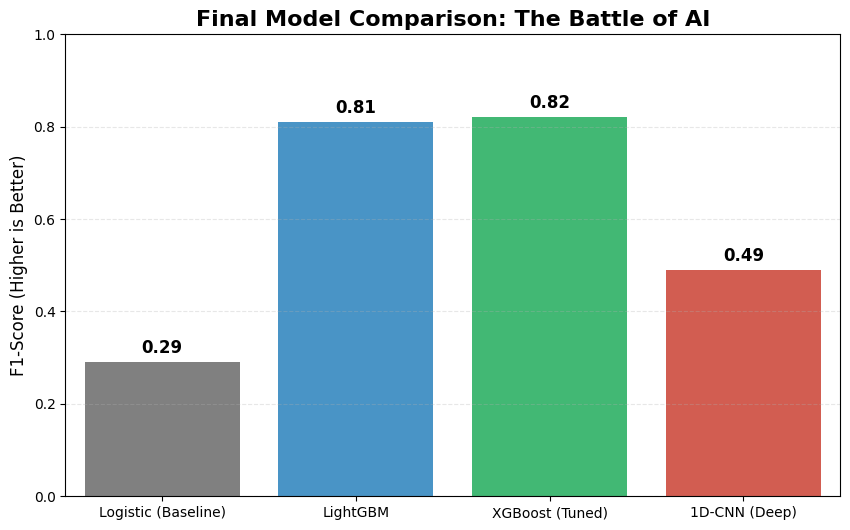

💾 Saving the Champion Model...

✅ SAVE SUCCESS!
1. predictive_maintenance_model.pkl (สมอง AI)
2. scaler.pkl (เครื่องมือแปลงหน่วย)
👉 กรุณาโหลด 2 ไฟล์นี้เก็บลงเครื่องคอมฯ ไว้ใช้ทำ Day 5 ครับ!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --- 1. สรุปคะแนนทั้งหมด (Leaderboard) ---
model_names = ['Logistic (Baseline)', 'LightGBM', 'XGBoost (Tuned)', '1D-CNN (Deep)']
f1_scores = [0.29, 0.81, 0.82, 0.49]

# สร้างกราฟเปรียบเทียบ
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=model_names, y=f1_scores, palette=['gray', '#3498db', '#2ecc71', '#e74c3c'])

# ตกแต่งกราฟ
plt.ylim(0, 1.0)
plt.title('Final Model Comparison: The Battle of AI', fontsize=16, fontweight='bold')
plt.ylabel('F1-Score (Higher is Better)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# ใส่ตัวเลขบนแท่งกราฟ
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.show()

# --- 2. Save "The Champion" (XGBoost) ---
# เราเลือก XGBoost (ที่จูน Weight=40 แล้ว) เป็นตัวจริง


print("💾 Saving the Champion Model...")

# สร้างตัวแปรใหม่ที่มั่นใจว่าเป็นตัวเทพสุด (Weight=40)
final_model = XGBClassifier(
    random_state=42,
    n_estimators=100,
    scale_pos_weight=40,  # ค่าทีเด็ดที่เราหาเจอ
    eval_metric='logloss'
)
final_model.fit(X_train_scaled, y_train)

# เซฟลงไฟล์
joblib.dump(final_model, 'predictive_maintenance_model.pkl')
joblib.dump(scaler, 'scaler.pkl') # อย่าลืมตัวแปลงหน่วย!

print("\n✅ SAVE SUCCESS!")
print("1. predictive_maintenance_model.pkl (สมอง AI)")
print("2. scaler.pkl (เครื่องมือแปลงหน่วย)")
print("👉 กรุณาโหลด 2 ไฟล์นี้เก็บลงเครื่องคอมฯ ไว้ใช้ทำ Day 5 ครับ!")

## Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# --- ขั้นตอน: ตรวจสอบความนิ่งของโมเดล (Cross-Validation) ---
print("🛡️ กำลังตรวจสอบความเสถียรของโมเดล (5-Fold CV)...")

# ใช้โมเดลแชมป์เปี้ยนของคุณ (สมมติว่าเป็น model_xgb หรือ final_model)
# กำหนดกติกา: แบ่ง 5 ส่วน, สับไพ่ก่อนแบ่ง (Shuffle)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ให้คอมพิวเตอร์ลองสอบ 5 สนาม แล้วเอาคะแนน F1 มาดู
# (X_train_scaled, y_train คือข้อมูลทั้งหมดที่เรามีสำหรับการเทรน)
scores = cross_val_score(final_model, X_train_scaled, y_train, cv=cv, scoring='f1')

print(f"\n📊 คะแนนสอบ 5 สนาม (F1-Scores): {scores}")
print(f"✅ คะแนนเฉลี่ย (Mean): {scores.mean():.4f}")
print(f"📉 ส่วนเบี่ยงเบน (Std):  {scores.std():.4f}")

# วิเคราะห์ผล
if scores.std() < 0.05:
    print("\nบทสรุป: โมเดล 'เสถียร' (Stable) ไว้ใจได้ ใช้งานจริงได้")
else:
    print("\nบทสรุป: โมเดล 'ผีเข้าผีออก' (Unstable) ต้องระวัง!")

🛡️ กำลังตรวจสอบความเสถียรของโมเดล (5-Fold CV)...

📊 คะแนนสอบ 5 สนาม (F1-Scores): [0.82568807 0.72727273 0.78095238 0.81904762 0.8       ]
✅ คะแนนเฉลี่ย (Mean): 0.7906
📉 ส่วนเบี่ยงเบน (Std):  0.0353

บทสรุป: โมเดล 'เสถียร' (Stable) ไว้ใจได้ ใช้งานจริงได้


## 8. Financial Impact Analysis (Business ROI)
Accuracy alone isn't enough and translate the model's performance into **Business Cost (€)**.

**Cost Matrix Assumptions:**
1.  **False Negative (Missed Failure):** \€12,500 (Machine breakdown, downtime, part damage).
2.  **False Positive (False Alarm):** \€500 (Technician inspection cost).
3.  **True Positive (Prevented Failure):** \€500 (Maintenance cost).

*Calculate the total estimated cost savings compared to a "Run-to-Failure" strategy.*

💶 Cost Analysis (Based on German Industry Standard):
🔹 Preventive Cost: €500 | 🔸 Failure Cost: €12,500
--------------------------------------------------
1. Default Threshold (0.50): Total Cost €184,000
2. Best Threshold    (0.01): Total Cost €141,000
🚀 SAVING per year: €43,000 (23.4%)


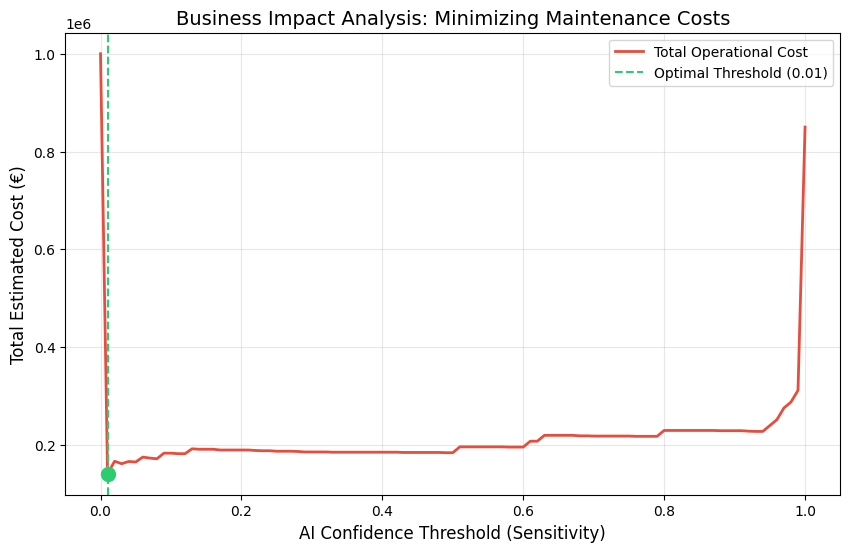

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- 1. สั่ง AI ทำนายความน่าจะเป็นก่อน! (บรรทัดที่หายไป) ---
# ต้องรันบรรทัดนี้ก่อน ถึงจะมีตัวแปร y_probs ไปคำนวณเงินครับ
# .predict_proba จะให้ค่าออกมา 2 คอลัมน์ [โอกาสไม่พัง, โอกาสพัง] -> เราเลือกคอลัมน์ 1 (โอกาสพัง)
y_probs = final_model.predict_proba(X_test_scaled)[:, 1]

# --- 2. ตั้งค่าสมมติฐาน (Reference: Germany Industrial Std.) ---
# หน่วยเป็น Euro (€)
COST_MAINTENANCE = 500      # ค่าซ่อมบำรุงตามปกติ (Labor + Minor Parts)
COST_FAILURE = 12500        # ค่าความเสียหายเมื่อพัง (Downtime + Major Parts)

# --- 3. คำนวณหาจุดคุ้มทุน (Cost Calculation) ---
thresholds = np.arange(0.0, 1.01, 0.01)
total_costs = []

for th in thresholds:
    y_pred_th = (y_probs >= th).astype(int)

    # นับจำนวนเคส (TN, FP, FN, TP)
    tn = ((y_test == 0) & (y_pred_th == 0)).sum()
    fp = ((y_test == 0) & (y_pred_th == 1)).sum() # AI ตื่นตูม (จ่าย 500)
    fn = ((y_test == 1) & (y_pred_th == 0)).sum() # AI พลาด (จ่าย 12,500)
    tp = ((y_test == 1) & (y_pred_th == 1)).sum() # AI จับได้ (จ่าย 500)

    # สูตรคำนวณเงินรวม
    cost = (fp * COST_MAINTENANCE) + (tp * COST_MAINTENANCE) + (fn * COST_FAILURE)
    total_costs.append(cost)

# --- 4. สรุปผล ---
min_cost = min(total_costs)
best_th = thresholds[np.argmin(total_costs)]
default_cost = total_costs[50] # ที่ Threshold 0.50

print(f"💶 Cost Analysis (Based on German Industry Standard):")
print(f"🔹 Preventive Cost: €{COST_MAINTENANCE:,.0f} | 🔸 Failure Cost: €{COST_FAILURE:,.0f}")
print("-" * 50)
print(f"1. Default Threshold (0.50): Total Cost €{default_cost:,.0f}")
print(f"2. Best Threshold    ({best_th:.2f}): Total Cost €{min_cost:,.0f}")
print(f"🚀 SAVING per year: €{default_cost - min_cost:,.0f} ({(default_cost - min_cost)/default_cost*100:.1f}%)")

# --- 5. กราฟ ROI (Business Impact) ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, total_costs, label='Total Operational Cost', color='#e74c3c', linewidth=2)
plt.axvline(best_th, color='#2ecc71', linestyle='--', label=f'Optimal Threshold ({best_th:.2f})')
plt.scatter(best_th, min_cost, color='#2ecc71', s=100, zorder=5)

plt.title('Business Impact Analysis: Minimizing Maintenance Costs', fontsize=14)
plt.xlabel('AI Confidence Threshold (Sensitivity)', fontsize=12)
plt.ylabel('Total Estimated Cost (€)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. AI Technical Consultant (RAG System)
Beyond prediction, we build a **Retrieval-Augmented Generation (RAG)** system to act as an AI Technical Consultant.

**Tech Stack:**
* **LangChain:** Framework for chaining LLM components.
* **Google Gemini (GenAI):** The Brain (LLM) for answering questions.
* **ChromaDB:** Vector Store for indexing technical manuals (PDFs).

**Workflow:**
1.  User asks a question (e.g., *"How to fix Fracture?"*).
2.  System retrieves relevant chunks from the uploaded PDF manual.
3.  Gemini generates an answer based *only* on the retrieved context (preventing hallucinations).

In [ ]:
# --- STEP 1: ติดตั้งเฉพาะตัวที่จำเป็น (Modern Stack) ---
!pip install -q -U langchain-text-splitters langchain-community langchain-google-genai chromadb pypdf google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0

In [ ]:
import os
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# --- 1. ตรวจสอบ API Key ---
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = "AIxxx" # <--- 🔑 ใส่ Key ของคุณตรงนี้

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)


In [ ]:
# 2. ฟังก์ชันค้นหาโมเดลอัตโนมัติ (แก้ปัญหา 404 Model Not Found)
print("🔍 กำลังสแกนหาโมเดล...")
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
valid_model = None
for m in genai.list_models():
    if 'generateContent' in m.supported_generation_methods and 'gemini' in m.name:
        valid_model = m.name
        if 'flash' in m.name or 'pro' in m.name: break # เจอตัวดีๆ แล้วหยุดหา
print(f"✅ ใช้รุ่น: {valid_model}")

🔍 กำลังสแกนหาโมเดล...
✅ ใช้รุ่น: models/gemini-2.5-flash


In [ ]:
import requests
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter # Fixed import path

# 3. เตรียมข้อมูล
if not os.path.exists("sumitomo_manual.pdf"):
    print("📥 กำลังดาวน์โหลดคู่มือ...")
    r = requests.get("https://www.sumitool.com/en/downloads/cutting-tools/general-catalog/assets/pdf/n2.pdf")
    with open("sumitomo_manual.pdf", 'wb') as f: f.write(r.content)

print("🧠 กำลังสร้างสมอง AI...")
loader = PyPDFLoader("sumitomo_manual.pdf")
docs = loader.load()
# ตัดข้อมูลเหลือ 40 ชิ้น (ย่อหน้า)
texts = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100).split_documents(docs)[:40]

# สร้าง Database
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
db = Chroma.from_documents(texts, embeddings)
print("✅ ฐานข้อมูลพร้อมใช้งาน!")

📥 กำลังดาวน์โหลดคู่มือ...
🧠 กำลังสร้างสมอง AI...
✅ ฐานข้อมูลพร้อมใช้งาน!


In [ ]:
# 4. ฟังก์ชันถาม-ตอบ (Manual RAG - แก้ปัญหา Library ตีกัน)
def ask_sumitomo(question):
    print(f"\n❓ คำถาม: {question}")

    # ค้นหาข้อมูลที่เกี่ยวข้อง
    docs = db.similarity_search(question, k=2)
    context = "\n".join([d.page_content for d in docs])

    # สร้าง Prompt
    prompt = f"""
    Answer based ONLY on the context below:
    Context: {context}
    Question: {question}
    Answer:
    """

    # ตอบ
    try:
        llm = ChatGoogleGenerativeAI(model=valid_model)
        result = llm.invoke(prompt)
        print(f"🤖 คำตอบ: {result.content}")
    except Exception as e:
        print(f"❌ Error: {e}")

In [ ]:
# --- Questions in first 40 ---

print("🧪 Testing Question 1: Fracture (การแตกหัก)")
ask_sumitomo("What are the causes and countermeasures for Fracture?")

print("\n🧪 Testing Question 2: Built-up Edge (เศษพอก)")
ask_sumitomo("What causes Built-up edge and how to fix it?")

print("\n🧪 Testing Question 3: Safety (ความปลอดภัย)")
ask_sumitomo("What are the general safety precautions when using cutting tools?")

🧪 Testing Question 1: Fracture (การแตกหัก)

❓ คำถาม: What are the causes and countermeasures for Fracture?
🤖 คำตอบ: **Causes:**
*   Tool grade lacks toughness.
*   Cutting edge is not strong enough.
*   Holder is not strong enough.
*   Feed rate and depth of cut are too large.

**Countermeasures:**
*   Select a tougher grade (P10P20P30 K01K10K20).
*   If it is due to excessive low speeds or very low feed rates, select a grade resistant to adhesion.
*   If the cause is thermal cracking, select a thermal impact resistant grade.
*   Select a negative/positive (or double negative) cutter type with a large peripheral cutting edge angle (a small approach angle).
*   Reinforce the cutting edge (honing).
*   Select a stronger chipbreaker (G  H) or a chipbreaker with a strong cutting edge.
*   Increase insert size (thickness in particular), with recommended Insert Thickness: 3.18  4.76mm.
*   Select a holder with a larger approach angle.
*   Select a holder with a larger shank size.
*   R

## 10. Saving Artifacts for Deployment
Finally, export the best-performing model and the scaler to be used in the **Streamlit Web App**.

* `predictive_maintenance_model.pkl`: The trained XGBoost classifier.
* `scaler.pkl`: The scaler used to normalize input data (crucial for consistent predictions).

In [ ]:
import joblib

# 1. บันทึกโมเดล (ตัวสุดท้ายจากลูป)
joblib.dump(model, 'predictive_maintenance_model.pkl')
print("✅ บันทึก Model สำเร็จ: predictive_maintenance_model.pkl")

# 2. บันทึกตัว Scaler (สำคัญ! ต้องใช้คู่กับโมเดล)
if 'scaler' in globals():
    joblib.dump(scaler, 'scaler.pkl')
    print("✅ บันทึก Scaler สำเร็จ: scaler.pkl")
else:
    print("⚠️ ไม่พบตัวแปร 'scaler' (ถ้าตอนเทรนไม่ได้ใช้ Scaler ก็ข้ามได้ครับ)")

✅ บันทึก Model สำเร็จ: predictive_maintenance_model.pkl
✅ บันทึก Scaler สำเร็จ: scaler.pkl
